## Introduction

MNIST ("Modified National Institute of Standards and Technology") is the de facto “Hello World” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, we aim to correctly identify digits from a dataset of tens of thousands of handwritten images. Kaggle has curated a set of tutorial-style kernels which cover everything from regression to neural networks. They hope to encourage us to experiment with different algorithms to learn first-hand what works well and how techniques compare.

## Approach

For this Demo, we will be using Keras (with TensorFlow as our backend) as the main package to create a simple neural network to predict, as accurately as we can, digits from handwritten images. In particular, we will be calling the Functional Model API of Keras, and creating a 4-layered and 5-layered neural network.

Also, we will be experimenting with various optimizers: the plain vanilla Stochastic Gradient Descent optimizer and the Adam optimizer. However, there are many other parameters, such as training epochs which will we will not be experimenting with.

In addition, the choice of hidden layer units are completely arbitrary and may not be optimal. This is yet another parameter which we will not attempt to tinker with. Lastly, we introduce dropout, a form of regularisation, in our neural networks to prevent overfitting.

## Result

Following our simulations on the cross validation dataset, it appears that a 4-layered neural network, using 'Adam' as the optimizer along with a learning rate of 0.01, performs best. We proceed to introduce dropout in the model, and use the model to predict for the test set.


Importing key libraries, and reading data

In [1]:
import pandas as pd
import numpy as np

np.random.seed(1212)

import keras
from keras.models import Model
from keras.layers import *
from keras import optimizers

2023-09-30 00:53:38.189461: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 00:53:38.215846: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-09-30 00:53:38.215877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-09-30 00:53:38.215898: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-30 00:53:38.221077: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-30 00:53:38.222342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [4]:
X_train.shape # (60000, 28, 28)

(60000, 28, 28)

## Data cleaning, normalization and selection

In [5]:
print((X_train.min()), 
      (X_train.max()))

0 255


As the pixel intensities are currently between the range of 0 and 255, we proceed to normalize the features, using broadcasting. In addition, we proceed to convert our labels from a class vector to binary One Hot Encoded

In [6]:
# Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


# Convert labels to One Hot Encoded
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [7]:
# Printing 2 examples of labels after conversion
print(y_train[0]) # 2
print(y_train[3]) # 7

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Splitting into training and validation dataset

In [8]:
# Create a validation set by taking a portion of X_train
X_val = X_train[50000:]
y_val = y_train[50000:]

# Update X_train and y_train to include only the first portion
X_train = X_train[:50000]
y_train = y_train[:50000]

print(X_val.shape)

(10000, 28, 28)


## Data visualization
Data visualization is an essential part of any data analysis or machine learning project, as it allows you to gain insights from your data and understand patterns and relationships. In the context of a MNIST handwriting recognition project,  visualize individual digits, and analyze the distribution of classes.

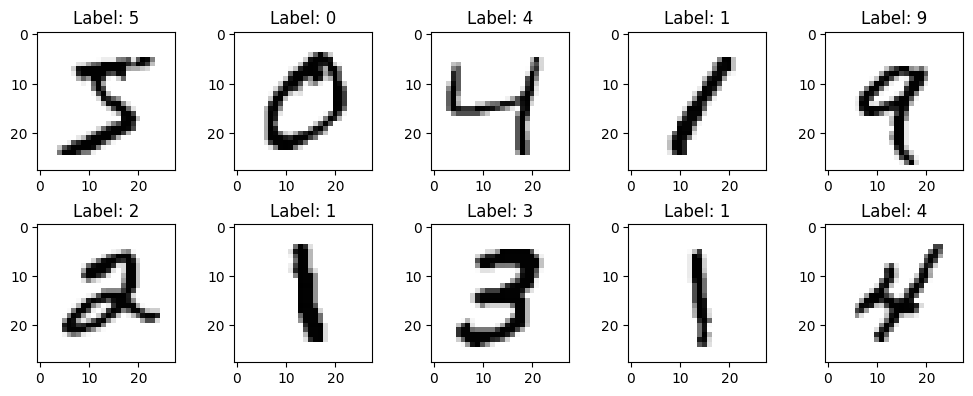

In [9]:
import matplotlib.pyplot as plt

# Display a few sample digits
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray_r')
    plt.title(f'Label: {np.argmax(y_train[i])}')
plt.tight_layout()
plt.show()


### Class Distribution:
Visualize the distribution of the different digit classes in your training dataset using a bar chart:

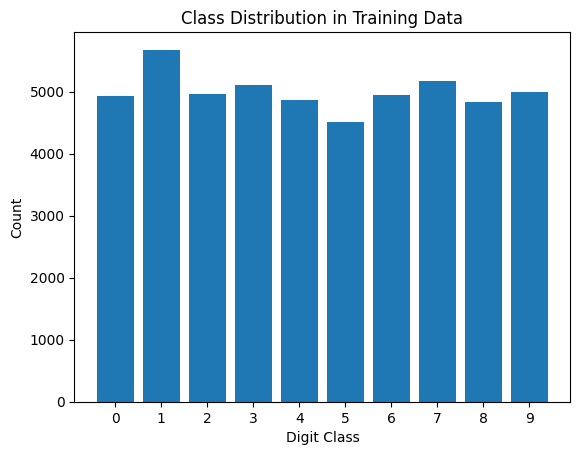

In [10]:
unique, counts = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(unique, counts)
plt.xticks(unique, [str(i) for i in unique])
plt.xlabel('Digit Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Data')
plt.show()


#### Data Preprocessing Check:
Visualize how your data looks after preprocessing (e.g., reshaping and normalizing). Display a few images to ensure they are in the desired format:

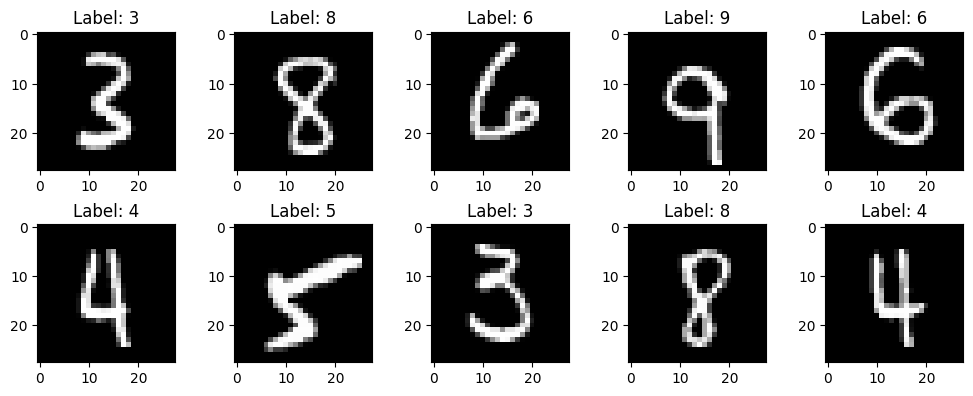

In [11]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_val[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {np.argmax(y_val[i])}')
plt.tight_layout()
plt.show()


## Model Fitting

We proceed by fitting several simple neural network models using Keras (with TensorFlow as our backend) and collect their accuracy. The model that performs the best on the validation set will be used as the model of choice for the competition.

Model 1: Simple Neural Network with 4 layers (300, 100, 100, 200)

In our first model, we will use the Keras library to train a neural network with the activation function set as ReLu. To determine which class to output, we will rely on the SoftMax function

In [16]:
# Input Parameters
n_input = (28, 28, 1) # number of features
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
num_digits = 10

In [19]:
from keras.models import Sequential
from keras.layers import Input, Dense


# Create a Sequential model
model = Sequential()

# Add layers to the model
model.add(Dense(n_hidden_1, activation='relu', input_shape=(n_input), name="Hidden_Layer_1"))
model.add(Dense(n_hidden_2, activation='relu', name="Hidden_Layer_2"))
model.add(Dense(n_hidden_3, activation='relu', name="Hidden_Layer_3"))
model.add(Dense(n_hidden_4, activation='relu', name="Hidden_Layer_4"))
model.add(Dense(num_digits, activation='softmax', name="Output_Layer"))


In [20]:
# Our model would have '6' layers - input layer, 4 hidden layer and 1 output layer
model.summary() # We have 297,910 parameters to estimate

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 28, 28, 300)       600       
                                                                 
 Hidden_Layer_2 (Dense)      (None, 28, 28, 100)       30100     
                                                                 
 Hidden_Layer_3 (Dense)      (None, 28, 28, 100)       10100     
                                                                 
 Hidden_Layer_4 (Dense)      (None, 28, 28, 200)       20200     
                                                                 
 Output_Layer (Dense)        (None, 28, 28, 10)        2010      
                                                                 
Total params: 63010 (246.13 KB)
Trainable params: 63010 (246.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Insert Hyperparameters
learning_rate = 0.1
training_epochs = 20
batch_size = 100
sgd = optimizers.SGD(lr=learning_rate)

In [22]:
# We rely on the plain vanilla Stochastic Gradient Descent as our optimizing methodology
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [23]:
history1 = model.fit(X_train, y_train,
                     batch_size = batch_size,
                     epochs = training_epochs,
                     verbose = 2,
                     validation_data=(X_val, y_val))

Epoch 1/20


2023-09-30 00:59:58.415362: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156800000 exceeds 10% of free system memory.


ValueError: in user code:

    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py", line 5575, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (100, 10) and (100, 28, 28, 10) are incompatible


Using a 4 layer neural network with:

1. 20 training epochs
2. A training batch size of 100
3. Hidden layers set as (300, 100, 100, 200)
4. Learning rate of 0.1

Achieved a training score of around 96-98% and a test score of around 95 - 97%.

Can we do better if we were to change the optimizer? To find out, we use the Adam optimizer for our second model, while maintaining the same parameter values for all other parameters.

In [24]:
Inp = Input(shape=n_input)
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

# We rely on ADAM as our optimizing methodology
adam = keras.optimizers.Adam(lr=learning_rate)
model2 = Model(Inp, output)

model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
history2 = model2.fit(X_train, y_train,
                      batch_size = batch_size,
                      epochs = training_epochs,
                      verbose = 2,
                      validation_data=(X_val, y_val))

Epoch 1/20


2023-09-30 01:02:03.604985: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156800000 exceeds 10% of free system memory.


ValueError: in user code:

    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py", line 5575, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (100, 10) and (100, 28, 28, 10) are incompatible


As it turns out, it does appear to be the case that the optimizer plays a crucial part in the validation score. In particular, the model which relies on 'Adam' as its optimizer tend to perform 1.5 - 2.5% better on average. Going forward, we will use 'Adam' as our optimizer of choice.

What if we changed the learning rate from 0.1 to 0.01, or 0.5? Will it have any impact on the accuracy?
Model 2A

In [ ]:
Inp = Input(shape=n_input)
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

learning_rate = 0.01
adam = keras.optimizers.Adam(lr=learning_rate)
model2a = Model(Inp, output)

model2a.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
history2a = model2a.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = training_epochs,
                        verbose = 2,
                        validation_data=(X_val, y_val))

NameError: name 'model2a' is not defined

Model 2B

In [ ]:
Inp = Input(shape=n_input)
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

learning_rate = 0.5
adam = keras.optimizers.Adam(lr=learning_rate)
model2b = Model(Inp, output)

model2b.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history2b = model2b.fit(X_train, y_train,
                        batch_size = batch_size,
                        epochs = training_epochs,
                            validation_data=(X_val, y_val))

The accuracy, as measured by the 3 different learning rates 0.01, 0.1 and 0.5 are around 98%, 97% and 98% respectively. As there are no considerable gains by changing the learning rates, we stick with the default learning rate of 0.01.

We proceed to fit a neural network with 5 hidden layers with the features in the hidden layer set as (300, 100, 100, 100, 200) respectively. To ensure that the two models are comparable, we will set the training epochs as 20, and the training batch size as 100.

In [ ]:
# Input Parameters
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 100
n_hidden_5 = 200
num_digits = 10

In [ ]:
Inp = Input(shape=n_input)
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
x = Dense(n_hidden_5, activation='relu', name = "Hidden_Layer_5")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

In [ ]:
# Our model would have '7' layers - input layer, 5 hidden layer and 1 output layer
model3 = Model(Inp, output)
model3.summary() # We have 308,010 parameters to estimate

In [ ]:
# We rely on 'Adam' as our optimizing methodology
adam = keras.optimizers.Adam(lr=0.01)

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history3 = model3.fit(X_train, y_train,
                      batch_size = batch_size,
                      epochs = training_epochs,
                      validation_data=(X_val, y_val))

Compared to our first model, adding an additional layer did not significantly improve the accuracy from our previous model. However, there are computational costs (in terms of complexity) in implementing an additional layer in our neural network. Given that the benefits of an additional layer are low while the costs are high, we will stick with the 4 layer neural network.

We now proceed to include dropout (dropout rate of 0.3) in our second model to prevent overfitting.

In [ ]:
# Input Parameters
n_hidden_1 = 300
n_hidden_2 = 100
n_hidden_3 = 100
n_hidden_4 = 200
num_digits = 10

In [ ]:
Inp = Input(shape=n_input)
x = Dense(n_hidden_1, activation='relu', name = "Hidden_Layer_1")(Inp)
x = Dropout(0.3)(x)
x = Dense(n_hidden_2, activation='relu', name = "Hidden_Layer_2")(x)
x = Dropout(0.3)(x)
x = Dense(n_hidden_3, activation='relu', name = "Hidden_Layer_3")(x)
x = Dropout(0.3)(x)
x = Dense(n_hidden_4, activation='relu', name = "Hidden_Layer_4")(x)
output = Dense(num_digits, activation='softmax', name = "Output_Layer")(x)

In [ ]:
# Our model would have '6' layers - input layer, 4 hidden layer and 1 output layer
model4 = Model(Inp, output)
model4.summary() # We have 297,910 parameters to estimate

In [ ]:
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [28]:
history = model4.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = training_epochs,
                    validation_data=(X_val, y_val))

NameError: name 'model4' is not defined

With a validation score of close to 98%, we proceed to use this model to predict for the test set.

In [ ]:
test_pred = pd.DataFrame(model4.predict(X_test, batch_size=200))
test_pred = pd.DataFrame(test_pred.idxmax(axis = 1))
test_pred.index.name = 'ImageId'
test_pred = test_pred.rename(columns = {0: 'Label'}).reset_index()
test_pred['ImageId'] = test_pred['ImageId'] + 1

test_pred.head()

Using this model, we are able to achieve a score of 0.976,